In [3]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(physical_devices))
if len(physical_devices) > 0:
    print("GPU detected:", physical_devices)
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)  # Set memory growth
else:
    print("No GPU detected. Running on CPU.")

TensorFlow version: 2.10.1
Num GPUs Available: 1
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Paths
train_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\train'
val_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\val'
test_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test'

In [6]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 7
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 20
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

In [7]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=[0.7, 1.3],
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda x: x + np.random.normal(0, 0.1, x.shape)
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 12137 images belonging to 7 classes.
Found 3474 images belonging to 7 classes.
Found 1737 images belonging to 7 classes.


In [9]:
# Model setup with DenseNet-121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model initially
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

In [ ]:
# Compile with Adam optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
# Custom callback for formatted output
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, phase_epochs, phase_name):
        super(CustomCallback, self).__init__()
        self.phase_epochs = phase_epochs  # Total epochs for this phase
        self.phase_name = phase_name      # "Initial" or "Fine-tuning"

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.lr.numpy()
        loss = logs.get('loss')
        accuracy = logs.get('accuracy')
        # Adjust epoch number based on phase
        if self.phase_name == "Fine-tuning":
            epoch_display = epoch + INITIAL_EPOCHS + 1
            total_display = TOTAL_EPOCHS
        else:
            epoch_display = epoch + 1
            total_display = self.phase_epochs
        print(f"\nEpoch {epoch_display}: Learning Rate: {lr:.6f}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

In [11]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [13]:
# Initial training
print(f"Initial training for {INITIAL_EPOCHS} epochs...")
initial_callback = CustomCallback(INITIAL_EPOCHS, "Initial")
history_initial = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=val_generator,
    verbose=1,
    callbacks=[initial_callback, early_stopping]
)

Initial training for 10 epochs...
Epoch 1/10
380/380 [==============================] - ETA: 0s - loss: 1.3630 - accuracy: 0.4890
Epoch 1: Learning Rate: 0.001000, Loss: 1.3630, Accuracy: 0.4890
380/380 [==============================] - 369s 921ms/step - loss: 1.3630 - accuracy: 0.4890 - val_loss: 0.9283 - val_accuracy: 0.6649
Epoch 2/10
380/380 [==============================] - ETA: 0s - loss: 1.0304 - accuracy: 0.6214
Epoch 2: Learning Rate: 0.001000, Loss: 1.0304, Accuracy: 0.6214
380/380 [==============================] - 296s 779ms/step - loss: 1.0304 - accuracy: 0.6214 - val_loss: 0.8200 - val_accuracy: 0.7021
Epoch 3/10
380/380 [==============================] - ETA: 0s - loss: 0.9321 - accuracy: 0.6560
Epoch 3: Learning Rate: 0.001000, Loss: 0.9321, Accuracy: 0.6560
380/380 [==============================] - 289s 760ms/step - loss: 0.9321 - accuracy: 0.6560 - val_loss: 0.7586 - val_accuracy: 0.7173
Epoch 4/10
380/380 [==============================] - ETA: 0s - loss: 0.8971 -

In [14]:
# Fine-tuning
base_model.trainable = True
fine_tune_at = 100  # Unfreeze layers after this index
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [15]:
# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
print(f"\nFine-tuning for {FINE_TUNE_EPOCHS} epochs...")
fine_tune_callback = CustomCallback(FINE_TUNE_EPOCHS, "Fine-tuning")
history_fine = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    initial_epoch=INITIAL_EPOCHS,
    validation_data=val_generator,
    verbose=1,
    callbacks=[fine_tune_callback, early_stopping]
)


Fine-tuning for 20 epochs...
Epoch 11/30
380/380 [==============================] - ETA: 0s - loss: 0.8082 - accuracy: 0.7077
Epoch 21: Learning Rate: 0.000100, Loss: 0.8082, Accuracy: 0.7077
380/380 [==============================] - 232s 589ms/step - loss: 0.8082 - accuracy: 0.7077 - val_loss: 0.5722 - val_accuracy: 0.7855
Epoch 12/30
380/380 [==============================] - ETA: 0s - loss: 0.5998 - accuracy: 0.7840
Epoch 22: Learning Rate: 0.000100, Loss: 0.5998, Accuracy: 0.7840
380/380 [==============================] - 221s 582ms/step - loss: 0.5998 - accuracy: 0.7840 - val_loss: 0.4987 - val_accuracy: 0.8253
Epoch 13/30
380/380 [==============================] - ETA: 0s - loss: 0.5200 - accuracy: 0.8113
Epoch 23: Learning Rate: 0.000100, Loss: 0.5200, Accuracy: 0.8113
380/380 [==============================] - 228s 599ms/step - loss: 0.5200 - accuracy: 0.8113 - val_loss: 0.4249 - val_accuracy: 0.8443
Epoch 14/30
380/380 [==============================] - ETA: 0s - loss: 0.465

In [ ]:
# Save model
model.save('densenet121_7classes_model.h5')-

In [18]:
# Confusion Matrix and Classification Report
test_generator.reset()  # Reset generator
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

55/55 [==============================] - 25s 427ms/step


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the test data
test_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for correct label ordering
)

# Get true labels from the 'test_ds' directory iterator
true_labels = test_ds.classes  # True labels

# Assuming 'model' is already trained
pred_probs = model.predict(test_ds)
pred_labels = np.argmax(pred_probs, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Display the confusion matrix
class_labels = list(test_ds.class_indices.keys())  # Get class labels from the generator
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

plt.title('Confusion Matrix DenseNet-121', fontsize=16)
plt.show()

Found 1737 images belonging to 7 classes.
55/55 [==============================] - 11s 209ms/step


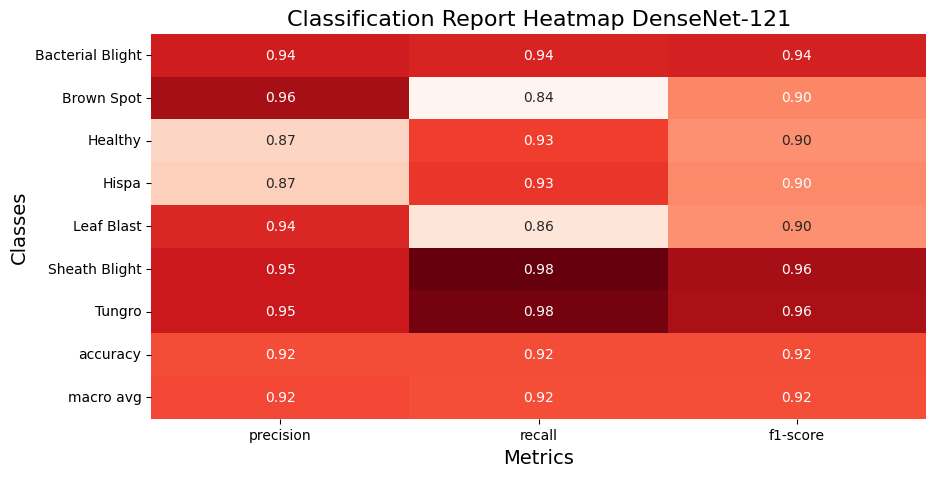

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the test data
test_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for correct label ordering
)

# Get true labels from the 'test_ds' directory iterator
true_labels = test_ds.classes  # True labels

# Assuming 'model' is already trained
pred_probs = model.predict(test_ds)
pred_labels = np.argmax(pred_probs, axis=1)  # Convert probabilities to class labels

# Generate a classification report
report = classification_report(true_labels, pred_labels, target_names=list(test_ds.class_indices.keys()), output_dict=True)

# Convert the report to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap=plt.cm.Reds, fmt=".2f", cbar=False)
plt.title('Classification Report Heatmap DenseNet-121', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Classes', fontsize=14)
plt.show()

# **Testing with Test Folder**

Found 1737 images belonging to 7 classes.
109/109 [==============================] - 14s 110ms/step - loss: 0.2684 - accuracy: 0.9223

Test Loss: 0.2684
Test Accuracy: 0.9223
109/109 [==============================] - 14s 113ms/step

Classification Report:
                  precision    recall  f1-score   support

Bacterial Blight       0.94      0.94      0.94       250
      Brown Spot       0.96      0.84      0.90       242
         Healthy       0.87      0.93      0.90       249
           Hispa       0.87      0.93      0.90       247
      Leaf Blast       0.94      0.86      0.90       250
   Sheath Blight       0.95      0.98      0.96       249
          Tungro       0.95      0.98      0.96       250

        accuracy                           0.92      1737
       macro avg       0.92      0.92      0.92      1737
    weighted avg       0.92      0.92      0.92      1737



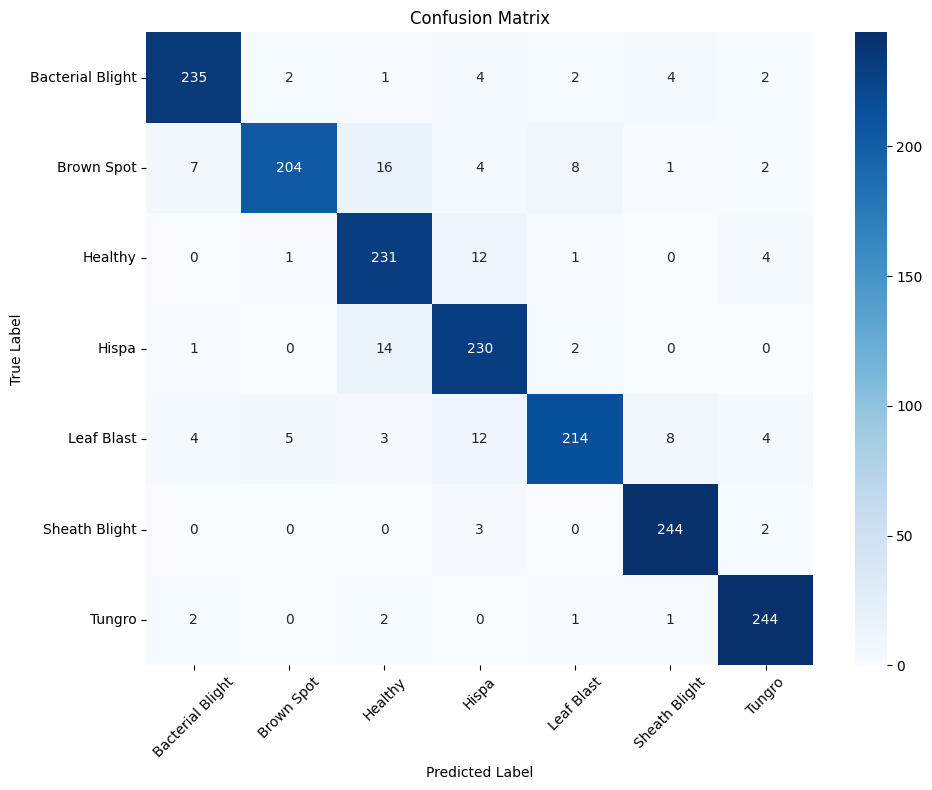

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Load the model weights
model = tf.keras.models.load_model('densenet121_7classes_model.h5')

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Test directory
test_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test'

# Image dimensions and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
test_generator.reset()  # Reset generator to start
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



109/109 [==============================] - 12s 113ms/step

Misclassified Images:
Image: D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test\Bacterial Blight\bacterial blight_0045.jpg, True Class: Bacterial Blight, Predicted Class: Brown Spot
Image: D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test\Bacterial Blight\bacterial blight_0219.jpg, True Class: Bacterial Blight, Predicted Class: Brown Spot
Image: D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test\Bacterial Blight\bacterial blight_0299.jpg, True Class: Bacterial Blight, Predicted Class: Healthy
Image: D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test\Bacterial Blight\bacterial blight_0464.jpg, True Class: Bacterial Blight, Predicted Class: Leaf Blast
Image: D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test\Bacterial Blight\bacterial blight_0582.jpg, True Class: Bacterial Blight, Predicted Class: Hispa
Image: D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test\Bacterial Blight\bacterial 

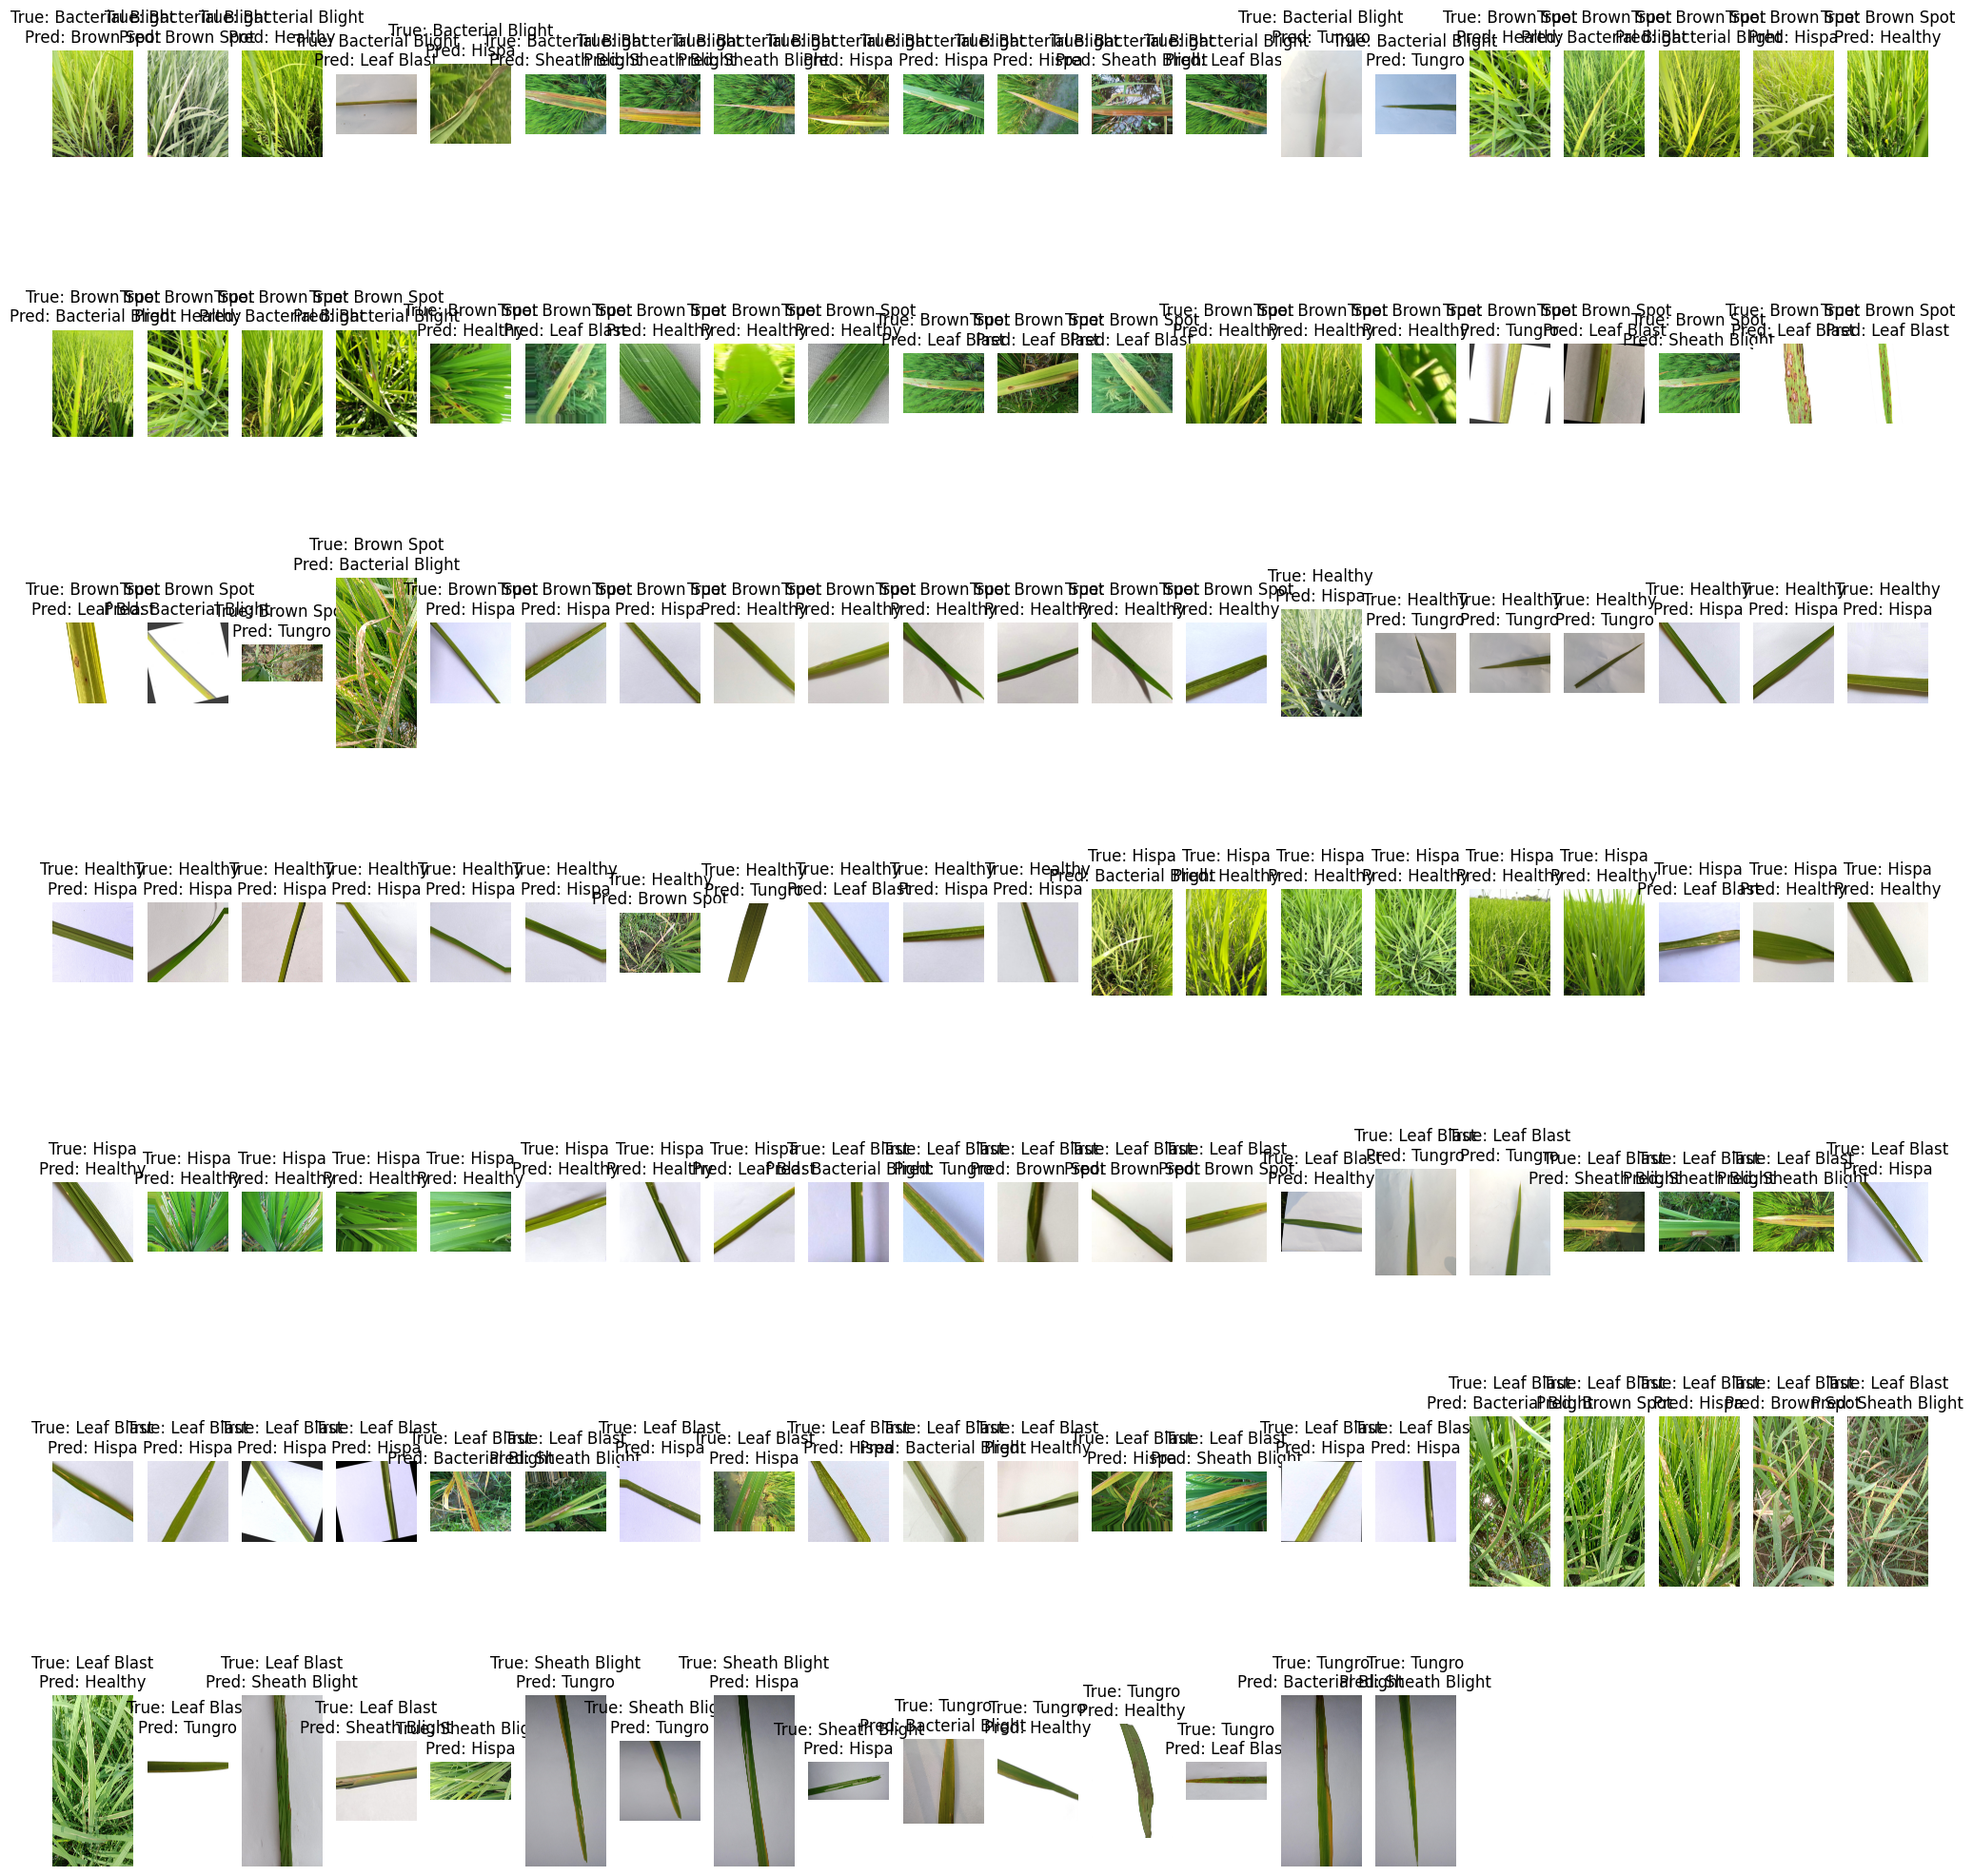

In [37]:
# Get file paths for each image in the test generator
test_generator.reset()  # Reset generator to start
file_paths = test_generator.filepaths  # Get the file paths from the generator

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Identify misclassified images
misclassified_indices = np.where(predicted_classes != true_classes)[0]
misclassified_images = [file_paths[i] for i in misclassified_indices]
misclassified_predictions = [predicted_classes[i] for i in misclassified_indices]
misclassified_true_classes = [true_classes[i] for i in misclassified_indices]

# Print misclassified images with their true and predicted labels
print("\nMisclassified Images:")
for i in range(len(misclassified_images)):
    print(f"Image: {misclassified_images[i]}, "
          f"True Class: {class_labels[misclassified_true_classes[i]]}, "
          f"Predicted Class: {class_labels[misclassified_predictions[i]]}")

# Optionally, you can display all misclassified images
import matplotlib.pyplot as plt

# Number of misclassified images
num_misclassified = len(misclassified_images)

# Set up the figure size based on the number of misclassified images
cols = 20  # Number of columns
rows = (num_misclassified + cols - 1) // cols  # Calculate rows needed

plt.figure(figsize=(20, rows * 3))  # Adjust height based on number of rows

for i, img_path in enumerate(misclassified_images):  # Loop through all misclassified images
    img = plt.imread(img_path)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_labels[misclassified_true_classes[i]]}\nPred: {class_labels[misclassified_predictions[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

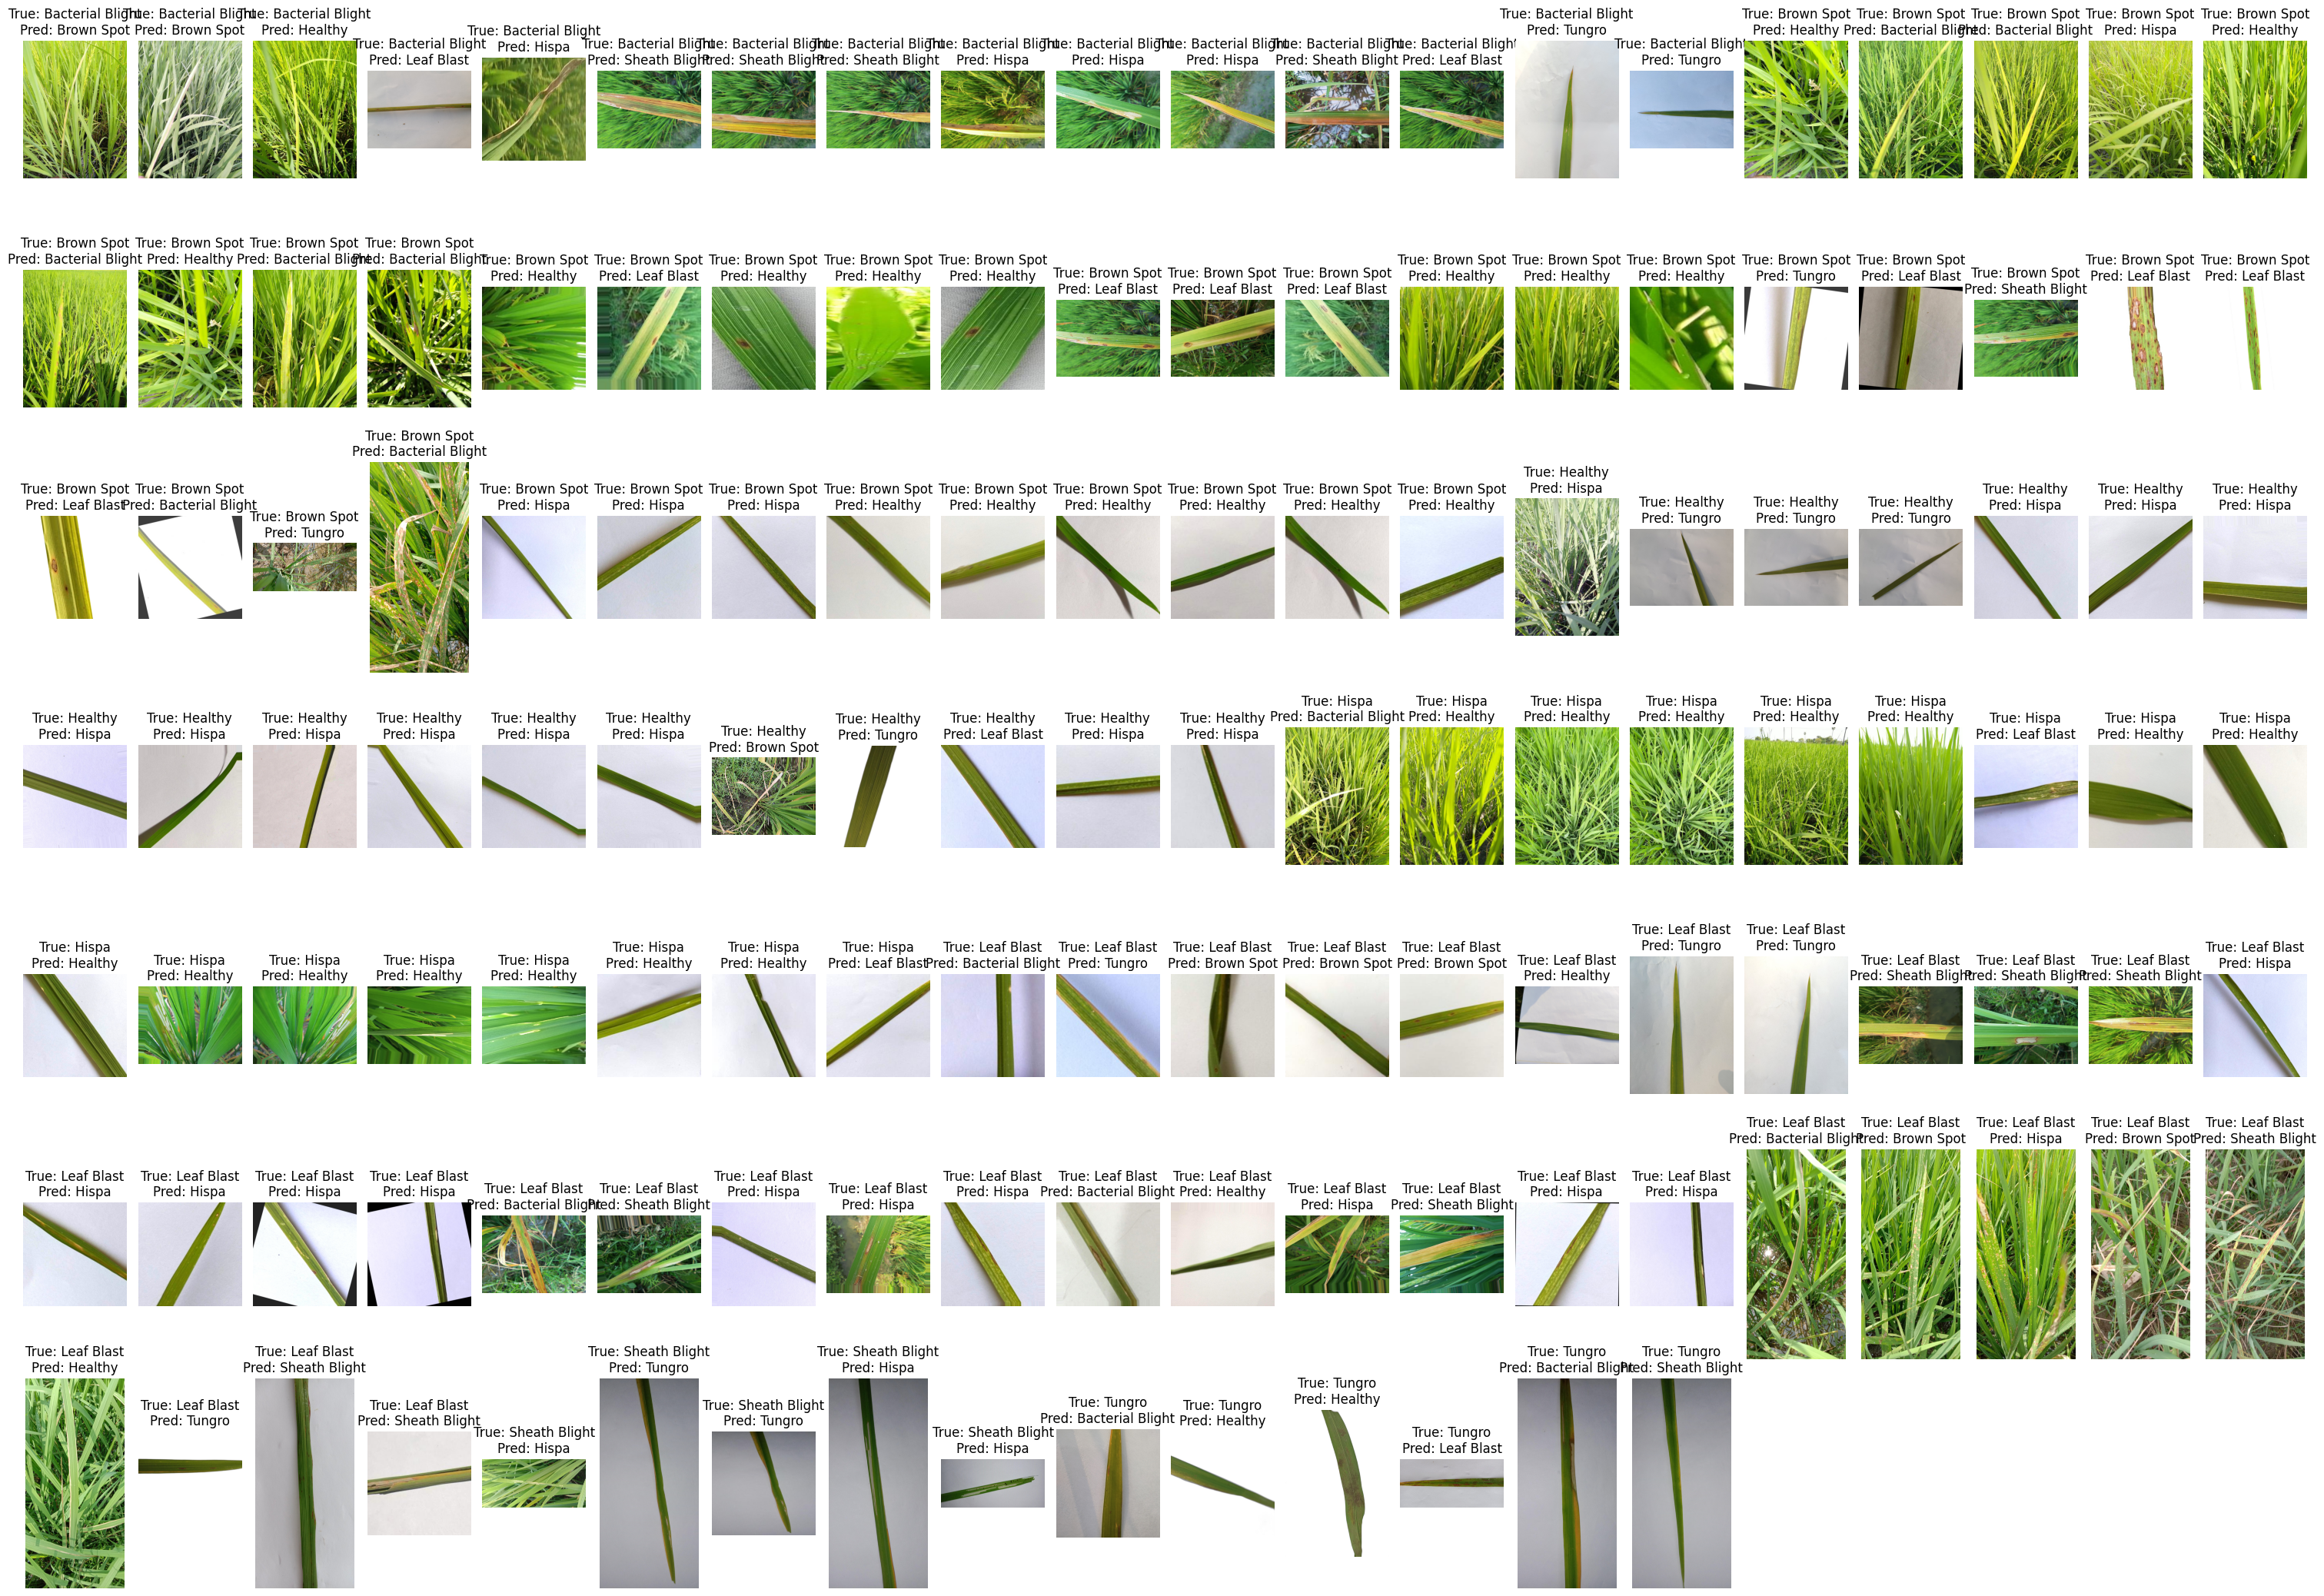

In [36]:
# Optionally, you can display all misclassified images
import matplotlib.pyplot as plt

# Number of misclassified images
num_misclassified = len(misclassified_images)

# Set up the figure size based on the number of misclassified images
cols = 20  # Number of columns
rows = (num_misclassified + cols - 1) // cols  # Calculate rows needed

plt.figure(figsize=(30, rows * 3))  # Adjust height based on number of rows

for i, img_path in enumerate(misclassified_images):  # Loop through all misclassified images
    img = plt.imread(img_path)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_labels[misclassified_true_classes[i]]}\nPred: {class_labels[misclassified_predictions[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()